# Step 2: Preprocess Data


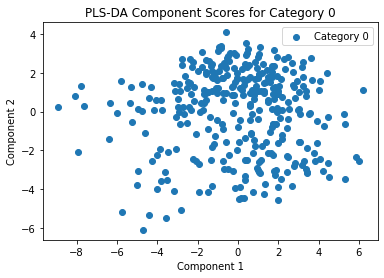

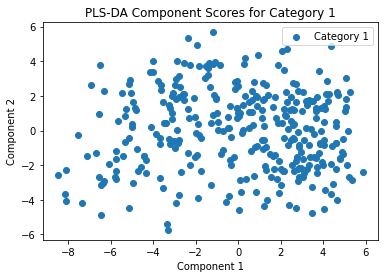

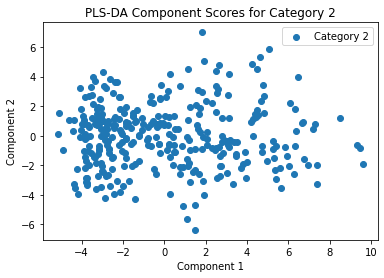

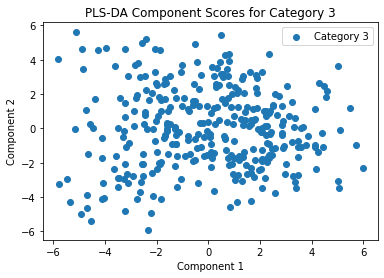

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
import numpy as np


# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[[col for col in data.columns if 'CL_' in col or 'FL_' in col]])

# One-hot encode the 'Category' column
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(data[['Category']]).toarray()

# Use PLSRegression for each category
pls_models = []
for i in range(y_encoded.shape[1]):  # Assuming each column is a category from OneHotEncoder
    pls = PLSRegression(n_components=2)
    pls.fit(X_scaled, y_encoded[:, i])
    pls_models.append(pls)

    # Print scores for the model of each category
#     print(f"Scores for category {i}:")
#     print(pls.x_scores_)

# Optionally, to see how different categories are separated, you can plot the scores
import matplotlib.pyplot as plt

for i, pls in enumerate(pls_models):
    plt.figure()
    plt.scatter(pls.x_scores_[:, 0], pls.x_scores_[:, 1], label=f'Category {i}')
    plt.title(f'PLS-DA Component Scores for Category {i}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()


# Optimize PLS Components

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sys import stdout

def optimise_pls_cv(X, y, n_comp, cv_folds=5, plot_components=True, verbose=True):
    """
    Optimize the number of PLS components and evaluate model performance using Seaborn for visualization with white background.
    
    Parameters:
        X (array-like): Predictor data.
        y (array-like): Response variable.
        n_comp (int): Maximum number of PLS components to test.
        cv_folds (int): Number of folds in cross-validation (default: 5).
        plot_components (bool): Whether to plot MSE for components (default: True).
        verbose (bool): Whether to print progress and results (default: True).
    
    Returns:
        None
    """
    sns.set(context='notebook', palette='deep', style="white", rc={'figure.facecolor':'white', 'axes.facecolor':'white'})
#     plt.style.use('ggplot')  # Adjust this as needed or remove if not required

    mse = []
    component = np.arange(1, n_comp + 1)
    
    for i in component:
        pls = PLSRegression(n_components=i)
        y_cv = cross_val_predict(pls, X, y, cv=cv_folds)
        mse.append(mean_squared_error(y, y_cv))
        
        if verbose:
            comp = 100 * (i / n_comp)
            stdout.write("\r%d%% completed" % comp)
            stdout.flush()

    msemin = np.argmin(mse)
    if verbose:
        stdout.write("\n")
        print("Suggested number of components: ", msemin + 1)
        stdout.write("\n")
    
    if plot_components:
        plt.figure(figsize=(10, 6))
        plt.plot(component, mse, '-v', color='blue', mfc='blue')
        plt.plot(component[msemin], mse[msemin], 'P', ms=10, mfc='red')
        plt.xlabel('Number of PLS Components')
        plt.ylabel('MSE')
        plt.title('PLS Component Optimization')
        plt.xlim(left=0)
        plt.show()

    pls_opt = PLSRegression(n_components=msemin + 1)
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    y_cv = cross_val_predict(pls_opt, X, y, cv=5)
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    
    if verbose:
        print('R2 calibration: %5.3f'  % score_c)
        print('R2 CV: %5.3f'  % score_cv)
        print('MSE calibration: %5.3f' % mse_c)
        print('MSE CV: %5.3f' % mse_cv)

    # Plot predicted vs measured
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_c, c='red', edgecolors='k')
    plt.plot(y, y, color='green', linewidth=1)  # Ideal 1:1 line
    plt.xlabel('Measured Values')
    plt.ylabel('Predicted Values')
    plt.title('Calibration and Cross-Validation')
    plt.show()

    return


In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sys import stdout


# Assuming the features and target are already selected and preprocessed
X = data[[col for col in data.columns if 'CL_' in col or 'FL_' in col]]  # Adjust this based on your actual feature columns
y = data['Weight (g)']  # Adjust if your target variable is different


100% completed
Suggested number of components:  5



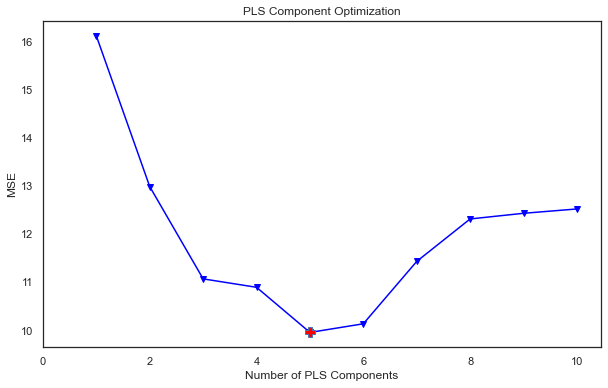

R2 calibration: 0.913
R2 CV: 0.899
MSE calibration: 8.554
MSE CV: 9.958


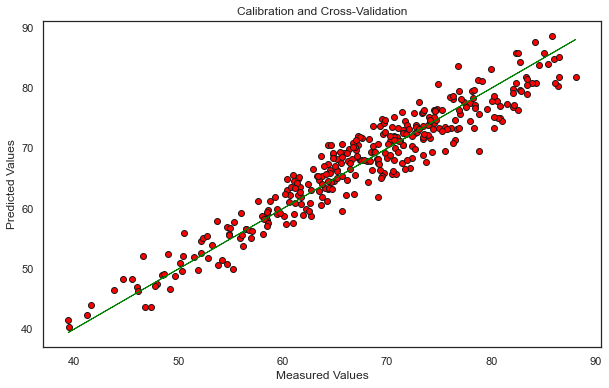

In [45]:
optimal_components = optimise_pls_cv(X, y, n_comp=10)  # Use a realistic number for n_comp based on your dataset


100% completed
Suggested number of components:  5



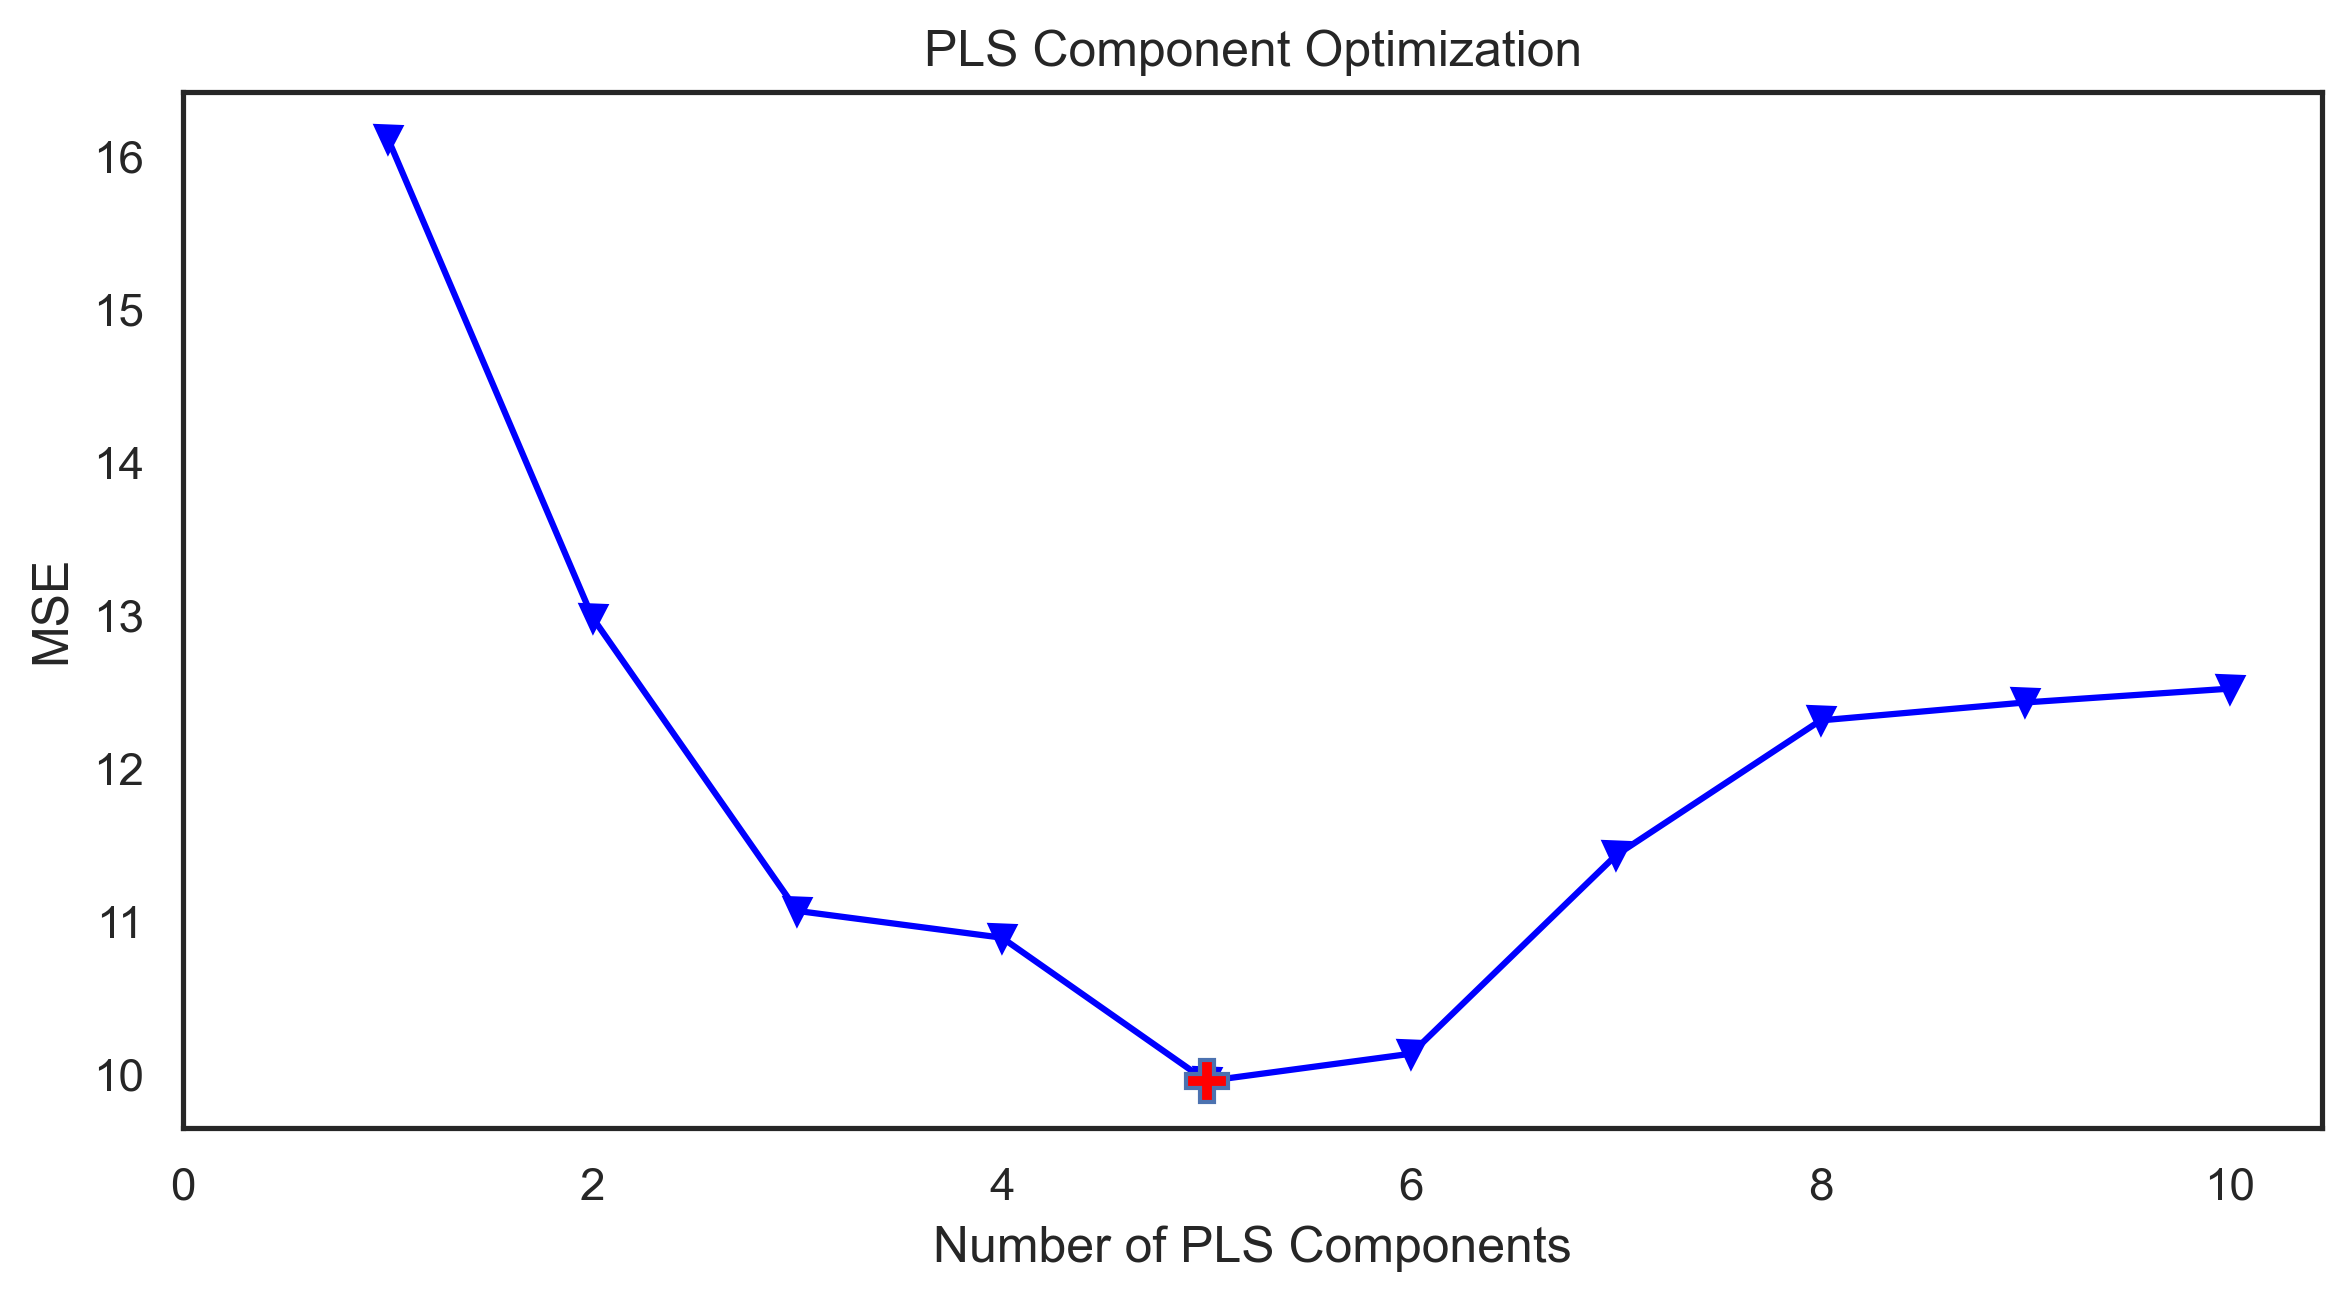

R2 calibration: 0.913
R2 CV: 0.899
MSE calibration: 8.554
MSE CV: 9.958


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sys import stdout

def optimise_pls_cv(X, y, n_comp, cv_folds=5, plot_components=True, verbose=True):
    """
    Optimize the number of PLS components and evaluate model performance using Seaborn for visualization with white background.
    
    Parameters:
        X (array-like): Predictor data.
        y (array-like): Response variable.
        n_comp (int): Maximum number of PLS components to test.
        cv_folds (int): Number of folds in cross-validation (default: 5).
        plot_components (bool): Whether to plot MSE for components (default: True).
        verbose (bool): Whether to print progress and results (default: True).
    
    Returns:
        None
    """
    sns.set(context='notebook', palette='deep', style="white", rc={'figure.facecolor':'white', 'axes.facecolor':'white'})

    mse = []
    component = np.arange(1, n_comp + 1)
    
    for i in component:
        pls = PLSRegression(n_components=i)
        y_cv = cross_val_predict(pls, X, y, cv=cv_folds)
        mse.append(mean_squared_error(y, y_cv))
        
        if verbose:
            comp = 100 * (i / n_comp)
            stdout.write("\r%d%% completed" % comp)
            stdout.flush()

    msemin = np.argmin(mse)
    if verbose:
        stdout.write("\n")
        print("Suggested number of components: ", msemin + 1)
        stdout.write("\n")
    
    if plot_components:
        plt.figure(figsize=(8, 4.5), dpi=300)  # Adjust the size and DPI here
        plt.plot(component, mse, '-v', color='blue', mfc='blue')
        plt.plot(component[msemin], mse[msemin], 'P', ms=10, mfc='red')
        plt.xlabel('Number of PLS Components')
        plt.ylabel('MSE')
        plt.title('PLS Component Optimization')
        plt.xlim(left=0)
        plt.tight_layout()  # Adjust layout to make sure labels, titles are within the canvas
        plt.savefig('PLS_Optimization.png')  # Save as PNG or any other format
        plt.show()

    pls_opt = PLSRegression(n_components=msemin + 1)
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    y_cv = cross_val_predict(pls_opt, X, y, cv=5)
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    
    if verbose:
        print('R2 calibration: %5.3f'  % score_c)
        print('R2 CV: %5.3f'  % score_cv)
        print('MSE calibration: %5.3f' % mse_c)
        print('MSE CV: %5.3f' % mse_cv)

    return

optimal_components = optimise_pls_cv(X, y, n_comp=10)  # Use a realistic number for n_comp based on your dataset


100% completed
Suggested number of components:  5



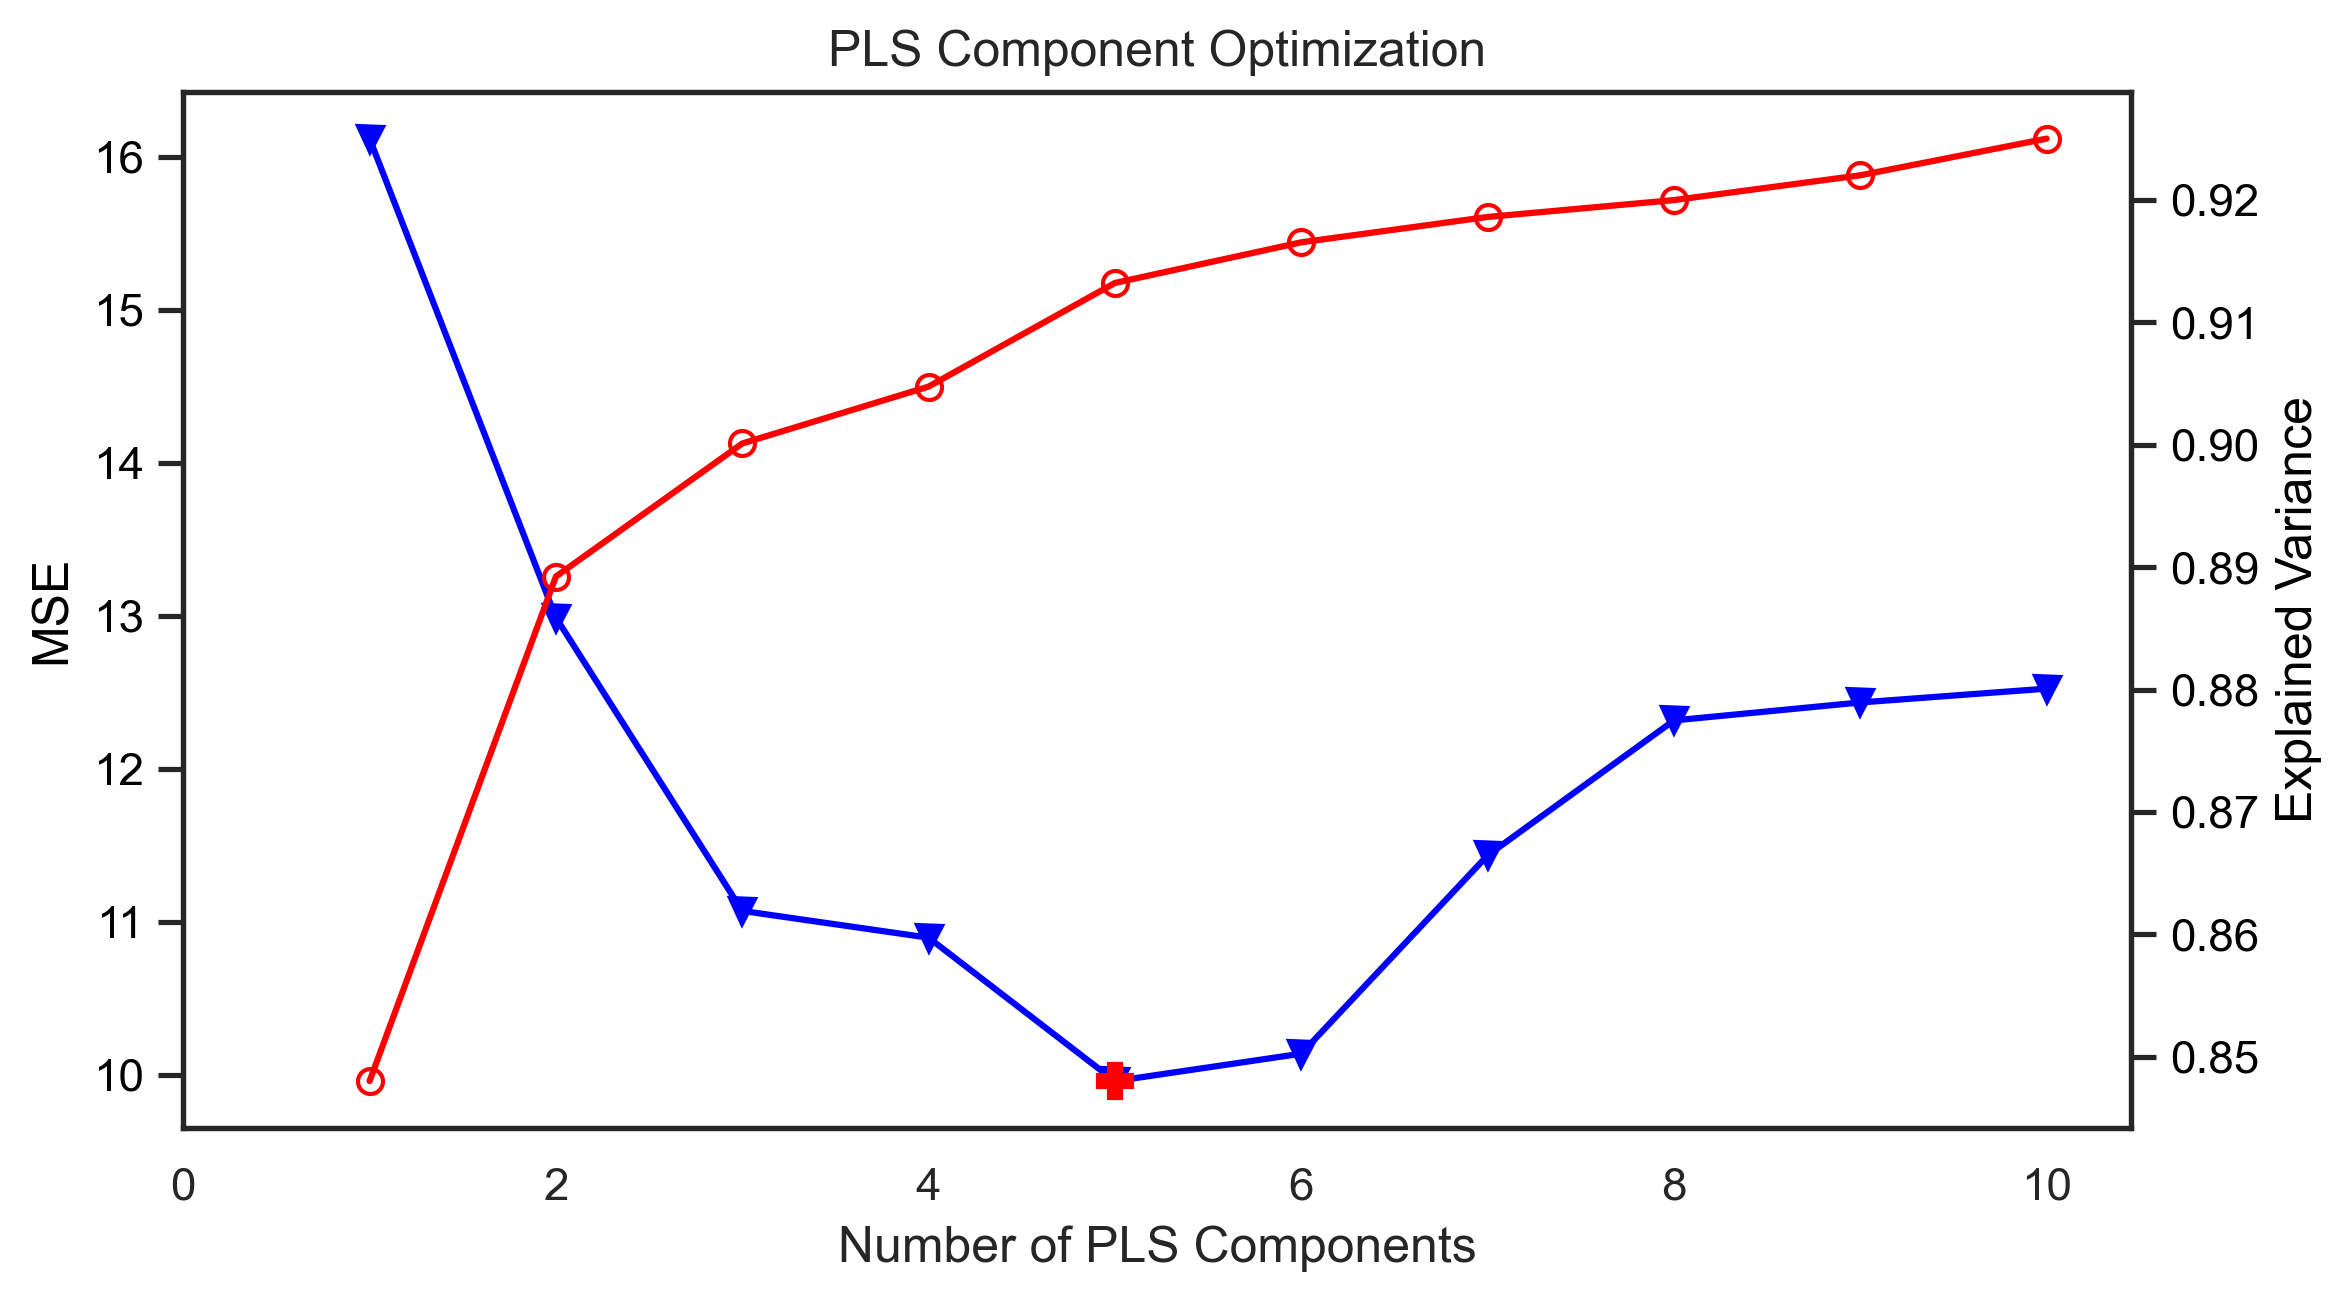

R2 calibration: 0.913
R2 CV: 0.899
MSE calibration: 8.554
MSE CV: 9.958


In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sys import stdout

def optimise_pls_cv(X, y, n_comp, cv_folds=5, plot_components=True, verbose=True):
    """
    Optimize the number of PLS components and evaluate model performance using Seaborn for visualization with dual axes.
    
    Parameters:
        X (array-like): Predictor data.
        y (array-like): Response variable.
        n_comp (int): Maximum number of PLS components to test.
        cv_folds (int): Number of folds in cross-validation (default: 5).
        plot_components (bool): Whether to plot MSE and explained variance for components on dual axes (default: True).
        verbose (bool): Whether to print progress and results (default: True).
    
    Returns:
        None
    """
    sns.set(context='notebook', palette='deep', style="white", rc={'figure.facecolor':'white', 'axes.facecolor':'white'})

    mse = []
    explained_variance = []
    component = np.arange(1, n_comp + 1)
    
    for i in component:
        pls = PLSRegression(n_components=i)
        y_cv = cross_val_predict(pls, X, y, cv=cv_folds)
        mse.append(mean_squared_error(y, y_cv))
        pls.fit(X, y)
        explained_variance.append(pls.score(X, y))
        
        if verbose:
            comp = 100 * (i / n_comp)
            stdout.write("\r%d%% completed" % comp)
            stdout.flush()

    msemin = np.argmin(mse)
    if verbose:
        stdout.write("\n")
        print("Suggested number of components: ", msemin + 1)
        stdout.write("\n")
    
    if plot_components:
        fig, ax1 = plt.subplots(figsize=(8, 4.5), dpi=300)
        
        # Plot MSE
        ax1.plot(component, mse, '-v', color='blue', mfc='blue', label='MSE')
        ax1.set_xlabel('Number of PLS Components')
        ax1.set_ylabel('MSE', color='black')
        ax1.tick_params(axis='y', labelcolor='black')
        
        # Highlight the minimum MSE point
        ax1.plot(component[msemin], mse[msemin], 'P', ms=8, mfc='red', mec='red', label='Minimum MSE')

        # Create a second y-axis for explained variance
        ax2 = ax1.twinx()
        ax2.plot(component, explained_variance, '-o', color='red', mfc='none', label='Explained Variance')
        ax2.set_ylabel('Explained Variance', color='black')
        ax2.tick_params(axis='y', labelcolor='black')
        
        plt.title('PLS Component Optimization')
        plt.xlim(left=0)
        plt.tight_layout()
        plt.savefig('PLS_Optimization_dual_axes.pdf')  # Save as PDF
        plt.show()

    pls_opt = PLSRegression(n_components=msemin + 1)
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    y_cv = cross_val_predict(pls_opt, X, y, cv=5)
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    
    if verbose:
        print('R2 calibration: %5.3f'  % score_c)
        print('R2 CV: %5.3f'  % score_cv)
        print('MSE calibration: %5.3f' % mse_c)
        print('MSE CV: %5.3f' % mse_cv)

    return
optimal_components = optimise_pls_cv(X, y, n_comp=10) 

100% completed
Suggested number of components:  5



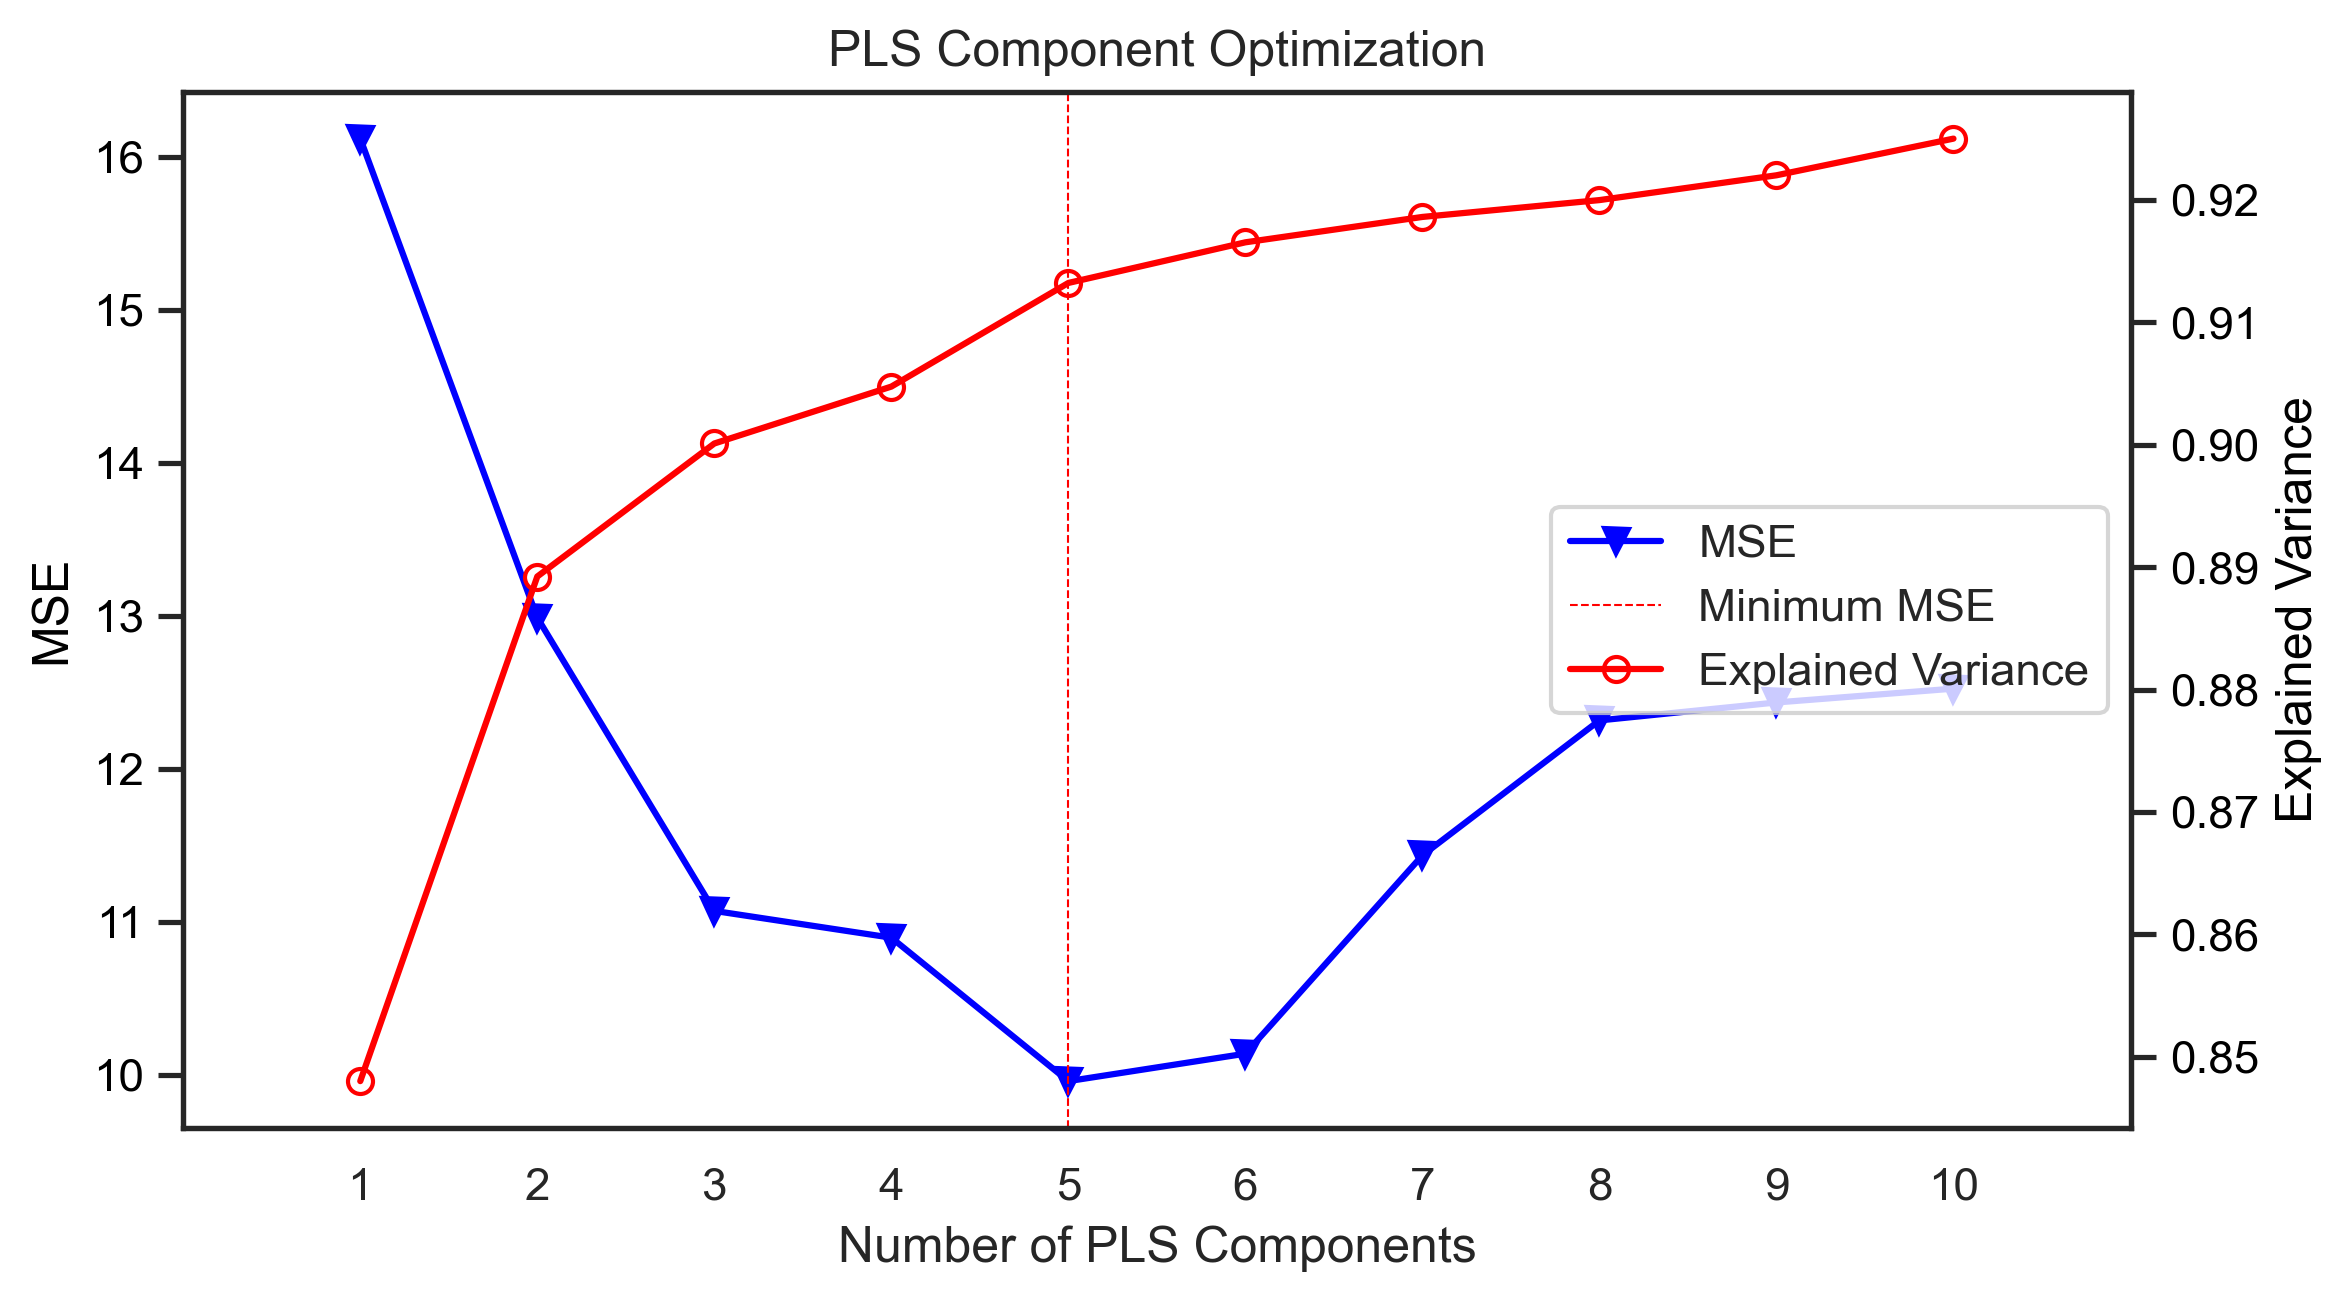

R2 calibration: 0.913
R2 CV: 0.899
MSE calibration: 8.554
MSE CV: 9.958


100% completed
Suggested number of components:  5



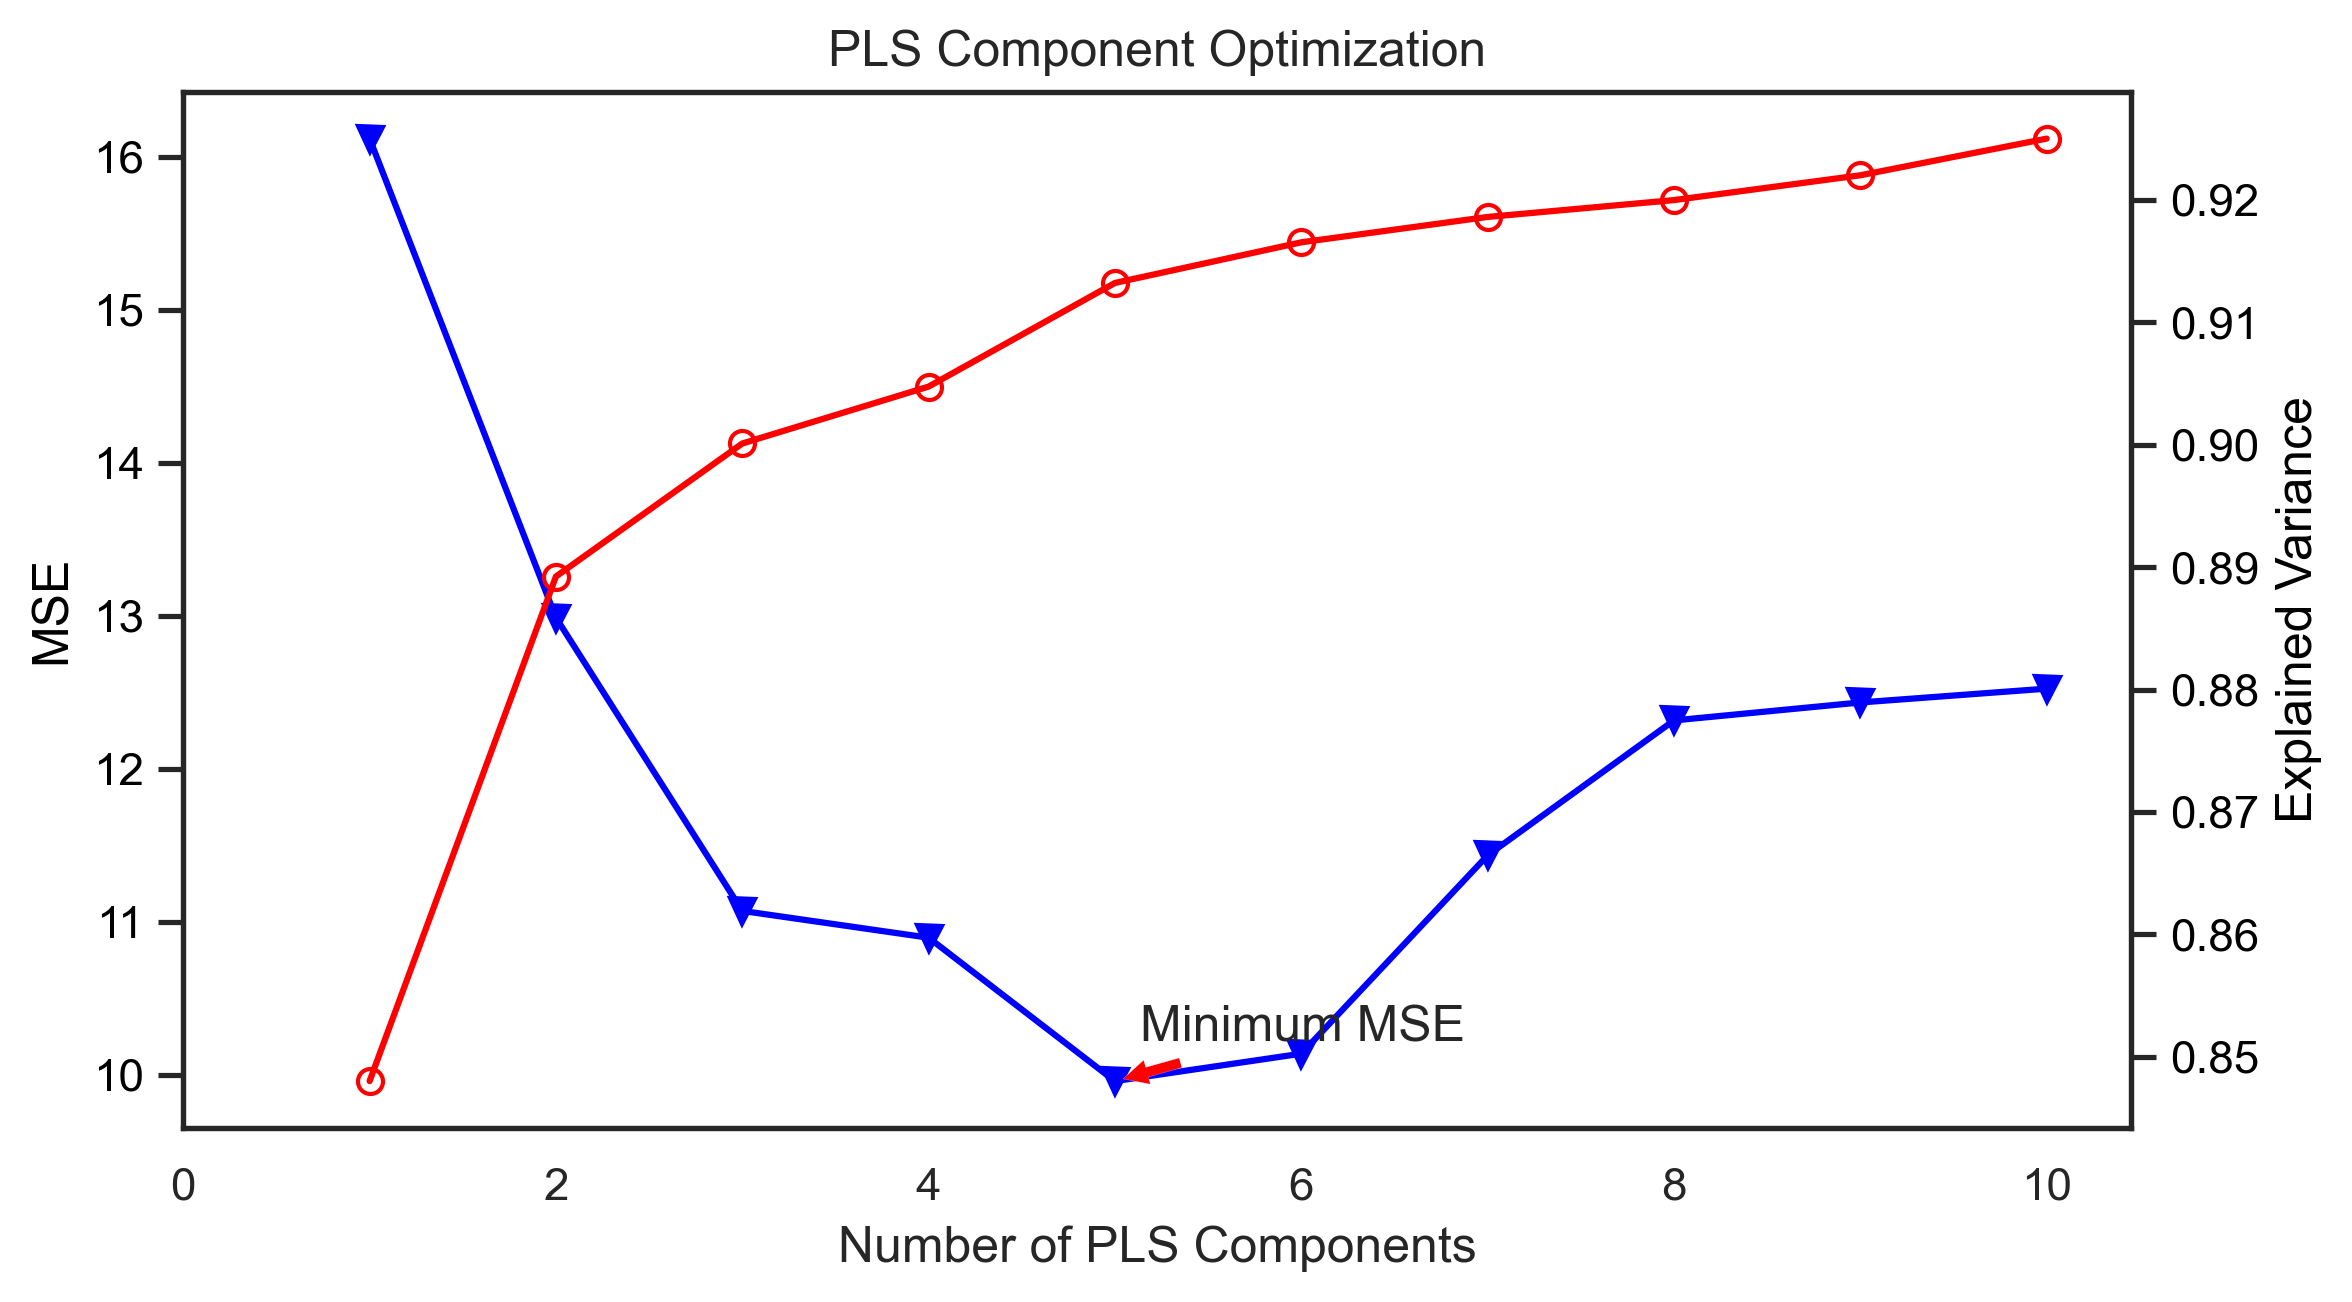

R2 calibration: 0.913
R2 CV: 0.899
MSE calibration: 8.554
MSE CV: 9.958


In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sys import stdout

def optimise_pls_cv(X, y, n_comp, cv_folds=5, plot_components=True, verbose=True):
    """
    Optimize the number of PLS components and evaluate model performance using Seaborn for visualization with dual axes and an arrow for minimum MSE.
    
    Parameters:
        X (array-like): Predictor data.
        y (array-like): Response variable.
        n_comp (int): Maximum number of PLS components to test.
        cv_folds (int): Number of folds in cross-validation (default: 5).
        plot_components (bool): Whether to plot MSE and explained variance for components on dual axes (default: True).
        verbose (bool): Whether to print progress and results (default: True).
    
    Returns:
        None
    """
    sns.set(context='notebook', palette='deep', style="white", rc={'figure.facecolor':'white', 'axes.facecolor':'white'})

    mse = []
    explained_variance = []
    component = np.arange(1, n_comp + 1)
    
    for i in component:
        pls = PLSRegression(n_components=i)
        y_cv = cross_val_predict(pls, X, y, cv=cv_folds)
        mse.append(mean_squared_error(y, y_cv))
        pls.fit(X, y)
        explained_variance.append(pls.score(X, y))
        
        if verbose:
            comp = 100 * (i / n_comp)
            stdout.write("\r%d%% completed" % comp)
            stdout.flush()

    msemin = np.argmin(mse)
    if verbose:
        stdout.write("\n")
        print("Suggested number of components: ", msemin + 1)
        stdout.write("\n")
    
    if plot_components:
        fig, ax1 = plt.subplots(figsize=(8, 4.5), dpi=300)
        
        # Plot MSE
        ax1.plot(component, mse, '-v', color='blue', mfc='blue', label='MSE')
        ax1.set_xlabel('Number of PLS Components')
        ax1.set_ylabel('MSE', color='black')
        ax1.tick_params(axis='y', labelcolor='black')
        
        # Highlight the minimum MSE point with an arrow
        ax1.annotate('Minimum MSE', xy=(component[msemin], mse[msemin]), xytext=(component[msemin] + 1, mse[msemin] - 0.5),
                     textcoords='offset points', arrowprops=dict(facecolor='red', 
                                                                 arrowstyle='simple', 
                                                                 lw=0.05))

        # Create a second y-axis for explained variance
        ax2 = ax1.twinx()
        ax2.plot(component, explained_variance, '-o', color='red', mfc='none', label='Explained Variance')
        ax2.set_ylabel('Explained Variance', color='black')
        ax2.tick_params(axis='y', labelcolor='black')
        
        plt.title('PLS Component Optimization')
        plt.xlim(left=0)
        plt.tight_layout()
        plt.savefig('PLS_Optimization_dual_axes-arrow.png')  # Save as PDF
        plt.show()

    pls_opt = PLSRegression(n_components=msemin + 1)
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    y_cv = cross_val_predict(pls_opt, X, y, cv=5)
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    
    if verbose:
        print('R2 calibration: %5.3f'  % score_c)
        print('R2 CV: %5.3f'  % score_cv)
        print('MSE calibration: %5.3f' % mse_c)
        print('MSE CV: %5.3f' % mse_cv)

    return

optimal_components = optimise_pls_cv(X, y, n_comp=10)


100% completed
Suggested number of components:  5



C:\Users\vinnr\AppData\Local\Temp/ipykernel_8224/4068930822.py:52: UserWarning:

linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-v" (-> linestyle='-'). The keyword argument will take precedence.

C:\Users\vinnr\AppData\Local\Temp/ipykernel_8224/4068930822.py:62: UserWarning:

linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.



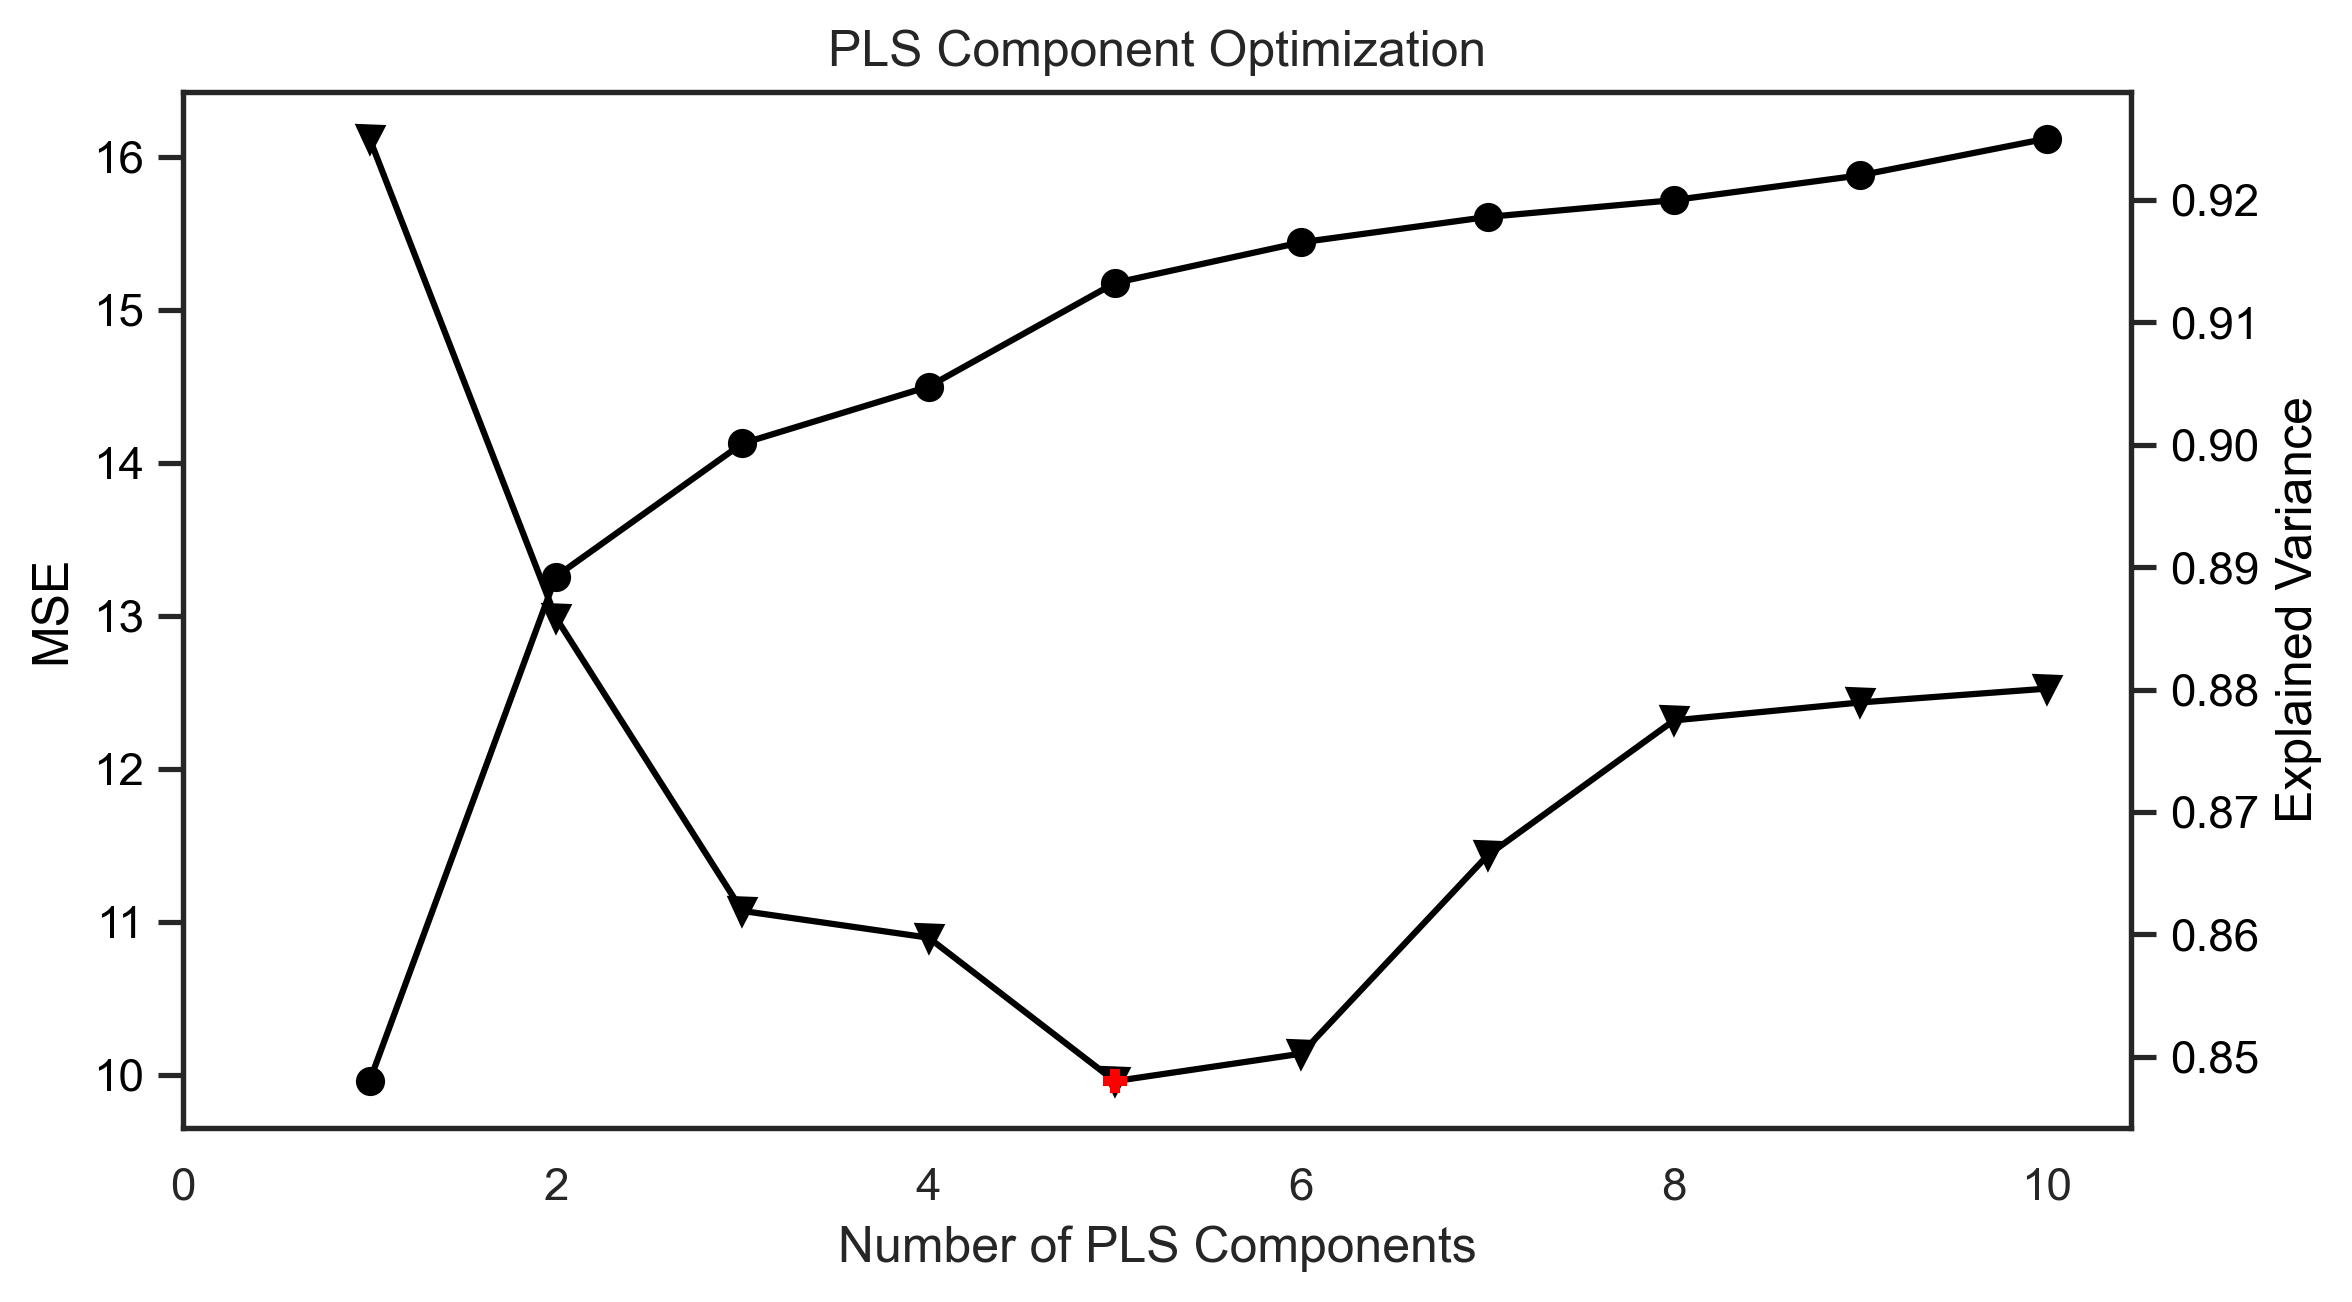

R2 calibration: 0.913
R2 CV: 0.899
MSE calibration: 8.554
MSE CV: 9.958


In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sys import stdout

def optimise_pls_cv(X, y, n_comp, cv_folds=5, plot_components=True, verbose=True):
    """
    Optimize the number of PLS components and evaluate model performance using Seaborn for visualization with dual axes and differentiated line styles.
    
    Parameters:
        X (array-like): Predictor data.
        y (array-like): Response variable.
        n_comp (int): Maximum number of PLS components to test.
        cv_folds (int): Number of folds in cross-validation (default: 5).
        plot_components (bool): Whether to plot MSE and explained variance for components on dual axes with different line styles (default: True).
        verbose (bool): Whether to print progress and results (default: True).
    
    Returns:
        None
    """
    sns.set(context='notebook', palette='deep', style="white", rc={'figure.facecolor':'white', 'axes.facecolor':'white'})

    mse = []
    explained_variance = []
    component = np.arange(1, n_comp + 1)
    
    for i in component:
        pls = PLSRegression(n_components=i)
        y_cv = cross_val_predict(pls, X, y, cv=cv_folds)
        mse.append(mean_squared_error(y, y_cv))
        pls.fit(X, y)
        explained_variance.append(pls.score(X, y))
        
        if verbose:
            comp = 100 * (i / n_comp)
            stdout.write("\r%d%% completed" % comp)
            stdout.flush()

    msemin = np.argmin(mse)
    if verbose:
        stdout.write("\n")
        print("Suggested number of components: ", msemin + 1)
        stdout.write("\n")
    
    if plot_components:
        fig, ax1 = plt.subplots(figsize=(8, 4.5), dpi=300)
        
        # Plot MSE with dashed line
        ax1.plot(component, mse, '-v', color='black', mfc='black', linestyle='-', label='MSE')
        ax1.set_xlabel('Number of PLS Components')
        ax1.set_ylabel('MSE', color='black')
        ax1.tick_params(axis='y', labelcolor='black')
        
        # Highlight the minimum MSE point
        ax1.plot(component[msemin], mse[msemin], 'P', ms=5, mfc='red', mec='red', label='Minimum MSE')

        # Create a second y-axis for explained variance with solid line
        ax2 = ax1.twinx()
        ax2.plot(component, explained_variance, '-o', color='black', mfc='black', linestyle='-', label='Explained Variance')
        ax2.set_ylabel('Explained Variance', color='black')
        ax2.tick_params(axis='y', labelcolor='black')
        
        plt.title('PLS Component Optimization')
        plt.xlim(left=0)
        plt.tight_layout()
        plt.savefig('PLS_Optimization_dual_axes-bw.png')  # Save as PDF
        plt.show()

    pls_opt = PLSRegression(n_components=msemin + 1)
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    y_cv = cross_val_predict(pls_opt, X, y, cv=5)
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    
    if verbose:
        print('R2 calibration: %5.3f'  % score_c)
        print('R2 CV: %5.3f'  % score_cv)
        print('MSE calibration: %5.3f' % mse_c)
        print('MSE CV: %5.3f' % mse_cv)

    return
optimal_components = optimise_pls_cv(X, y, n_comp=10)


In [41]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    mse = []
    component = np.arange(1, n_comp + 1)
    
    for i in component:
        pls = PLSRegression(n_components=i)
        y_cv = cross_val_predict(pls, X, y, cv=5)
        mse.append(mean_squared_error(y, y_cv))
        comp = 100 * (i + 1) / n_comp
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    
    # Identify the minimum MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin + 1)
    
    if plot_components:
        plt.figure(figsize=(10, 6))
        plt.plot(component, np.array(mse), '-v', color='blue', mfc='blue')
        plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
        plt.xlabel('Number of PLS components')
        plt.ylabel('MSE')
        plt.title('PLS Component Optimization')
        plt.xlim(left=-1)
        plt.show()
    
    return msemin + 1  # This ensures that the function returns the optimal number of components


110% completed
Suggested number of components:  5


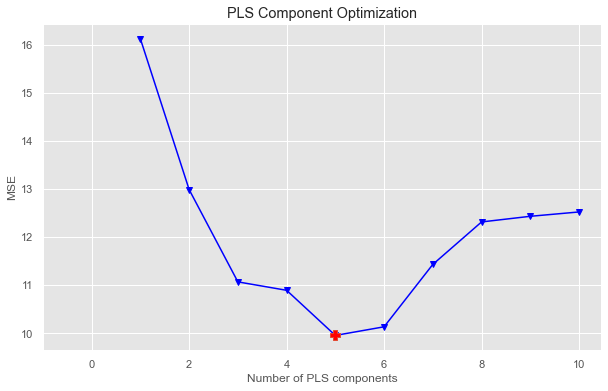

Optimal number of components: 5
R2 Score: 0.9132203129476342


In [42]:
optimal_components = optimise_pls_cv(X, y, n_comp=10)  # Assume n_comp is realistic for your dataset
print("Optimal number of components:", optimal_components)

pls_model = PLSRegression(n_components=optimal_components)
pls_model.fit(X, y)
y_pred = pls_model.predict(X)

print("R2 Score:", r2_score(y, y_pred))


104% completed


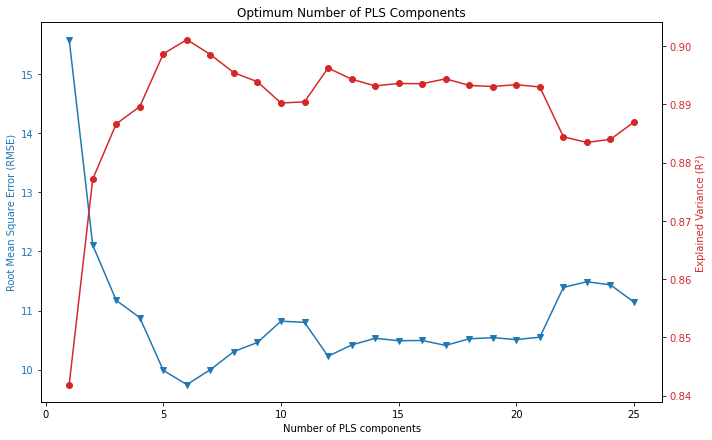

Optimal number of components: 6
Maximum R²: 0.9011001949969714


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sys import stdout

def optimise_pls_cv(X, y, n_comp, plot_components=True):
    mse = []
    r2 = []
    component = np.arange(1, n_comp + 1)
    
    for i in component:
        pls = PLSRegression(n_components=i)
        y_cv = cross_val_predict(pls, X, y, cv=10)
        
        mse.append(mean_squared_error(y, y_cv))
        r2.append(r2_score(y, y_cv))
        
        comp = 100 * (i + 1) / n_comp
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    
    if plot_components:
        fig, ax1 = plt.subplots(figsize=(10, 6))
        
        # Plotting RMSE
        color = 'tab:blue'
        ax1.set_xlabel('Number of PLS components')
        ax1.set_ylabel('Root Mean Square Error (RMSE)', color=color)
        ax1.plot(component, mse, '-v', color=color, mfc=color)
        ax1.tick_params(axis='y', labelcolor=color)
        
        # Create a second y-axis to plot the R2
        ax2 = ax1.twinx() 
        color = 'tab:red'
        ax2.set_ylabel('Explained Variance (R²)', color=color)
        ax2.plot(component, r2, '-o', color=color, mfc=color)
        ax2.tick_params(axis='y', labelcolor=color)
        
        fig.tight_layout()
        plt.title('Optimum Number of PLS Components')
        plt.show()
    
    return np.argmin(mse) + 1, np.max(r2)

# Usage
optimal_components, max_r2 = optimise_pls_cv(X, y, n_comp=25)
print("Optimal number of components:", optimal_components)
print("Maximum R²:", max_r2)


In [20]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV

# Define the model
pls = PLSRegression()

# Define the parameter grid
param_grid = {'n_components': range(1, 10)}

# Setup the grid search
grid_search = GridSearchCV(estimator=pls, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)


grid_search.fit(X, y)

# Best model result
print("Best number of components:", grid_search.best_params_)
print("Best score (negative MSE):", grid_search.best_score_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best number of components: {'n_components': 5}
Best score (negative MSE): -9.958012520334265


In [18]:
# Use the best model settings found by GridSearchCV
pls_final = PLSRegression(n_components=5)
pls_final.fit(X, y)

# Make predictions
y_pred = pls_final.predict(X)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
print("Final Model MSE:", mean_squared_error(y, y_pred))
print("Final Model R2:", r2_score(y, y_pred))


Final Model MSE: 8.553786740695898
Final Model R2: 0.9132203129476342


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'predictions' is your array of predicted values from the PLSR model
# and 'actuals' is the actual values from the dataset
# 'categories' is your conditions array from the 'Category' column
data = pd.DataFrame({
    'Predicted': predictions,
    'Actual': actuals,
    'Category': categories
})

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', hue='Category', data=data, palette='Set1', style='Category')
plt.plot([data['Actual'].min(), data['Actual'].max()], [data['Actual'].min(), data['Actual'].max()], 'k--') # Ideal line
plt.title('Prediction Accuracy by Treatment Condition')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend(title='Category')
plt.show()


NameError: name 'predictions' is not defined